# Project 2: Data Representations and Clustering
#### Serena Tang, Liwen Yang, Winston Wang

### Clustering with Sparse Text Representations

*1. Generate sparse TF-IDF representations: Following the steps in Project 1, transform the documents into TF-IDF vectors. Use min df = 3, exclude the stopwords (no need to do stemming or lemmatization), and remove the headers and footers. No need to do any additional data cleaning.*

In [1]:
from sklearn.datasets import fetch_20newsgroups

# get dataset
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                  'rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']
newsgroups = fetch_20newsgroups(categories=categories, remove=('headers', 'footers'))

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# count vectorizer on corpus
tf_vectorizer = CountVectorizer(min_df = 3, stop_words='english')
newsgroups_vectorized = tf_vectorizer.fit_transform(newsgroups.data)

# count vector to TF-IDF
transformer = TfidfTransformer()
newsgroups_tfidf = transformer.fit_transform(newsgroups_vectorized)

print('Newsgroups TF-IDF Dimensions: ', newsgroups_tfidf.shape)

Newsgroups TF-IDF Dimensions:  (4732, 17131)


### QUESTION 1
- ***Report the dimensions of the TF-IDF matrix you obtain.***
    - The newsgroups TF-IDF matrix had a dimension of (4732, 13477). 

*2. Clustering: Apply K-means clustering with k = 2 using the TF-IDF data. Note that the KMeans class in sklearn has parameters named random state, max iter and n init. Please use `random state=0`, `max iter ≥1000`, and `n_init ≥30`. You can refer to sklearn - Clustering text documents using k-means for a basic work flow.*
- *(a) Given the clustering result and ground truth labels, contingency table A is the matrix whose entries $A_{ij}$ is the number of data points that belong to the i’th class and the j’th cluster.*

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Get clusters
kmeans = KMeans(random_state=0, n_clusters=2, max_iter=1000, n_init=30)
kmeans.fit(newsgroups_tfidf )

KMeans(max_iter=1000, n_clusters=2, n_init=30, random_state=0)

In [4]:
# Map the categories to classes
class_1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class_2=['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
category_to_class=[]
cat_to_num={}
for idx, cat in enumerate(newsgroups.target_names):
    cat_to_num[idx]=cat
for num in newsgroups.target:
    if 'comp.' in cat_to_num[num]:
        category_to_class.append(0)
    else:
        category_to_class.append(1)

<Figure size 432x288 with 0 Axes>

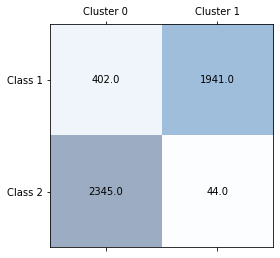

In [5]:
from sklearn import metrics

# plot contingency matrix
fig = plt.figure()
cont_matrix = metrics.cluster.contingency_matrix(category_to_class, kmeans.labels_)
plt.matshow(cont_matrix, cmap=plt.cm.Blues, alpha=0.4)
for (i, j), z in np.ndenumerate(cont_matrix):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xticks(range(2), ['Cluster 0', 'Cluster 1'])
plt.yticks(range(2), ['Class 1', 'Class 2'])
plt.show()

### QUESTION 2

***Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix. Does the contingency matrix have to
be square-shaped?***
- The contingency table of the clustering result is shown above. Based on the strong diagonal, we can infer that `Cluster 1` correlates to `Class 1` and `Cluster 0` correlates to `Class 2`. The contingency matrix should be square-shaped as we set the number of clusters in Kmeans to be 2 and our data has 2 classes. If we set the number of clusters in Kmeans to be a different number than the number of classes in the data, the contingency matrix will not be square. 

### Question 3
***Report the 5 clustering measures explained in the introduction for K-means clustering.***

In [6]:
from sklearn.metrics import cluster

# print clustering measures
print("Homogeneity: ", cluster.homogeneity_score(category_to_class, kmeans.labels_))
print("Completeness: ",cluster. completeness_score(category_to_class, kmeans.labels_))
print("V-measure: ", cluster.v_measure_score(category_to_class, kmeans.labels_))
print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(category_to_class, kmeans.labels_))
print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, kmeans.labels_, sample_size=2000))

Homogeneity:  0.586944967644873
Completeness:  0.5981422594612767
V-measure:  0.5924907147701187
Adjusted Rand-Index:  0.658454925051644
Silhouette Coefficient:  0.004832403443229149


### Question 4
***Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.***

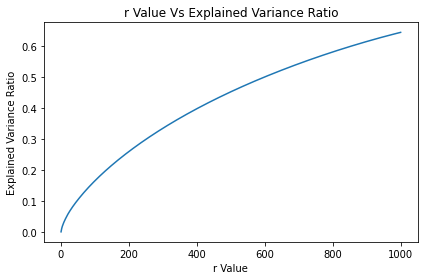

In [7]:
from sklearn.decomposition import TruncatedSVD

# get principle components
svd_1000 = TruncatedSVD(n_components=1000, random_state=0)
newsgroups_lsi = svd_1000.fit_transform(newsgroups_tfidf)

# get explained variance ratio
x = list(range(1, 1001))
ratio = svd_1000.explained_variance_ratio_
ex_var = np.cumsum(ratio)

# plot explained variance ratio
plt.plot(x, ex_var)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('r Value')
plt.title('r Value Vs Explained Variance Ratio')
plt.tight_layout()

### Question 5
***Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1−10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD
and NMF. Report a good choice of r for SVD and NMF respectively. Note: In the choice of r, there is a trade-off between the information preservation, and better performance of
k-means in lower dimensions.***
- The plots are shown below. Based on the results, r=50 is a good choice for SVD and r=2 is a good choise for NMF.

In [8]:
from sklearn.decomposition import NMF

r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]

def SVD_score(r,k,X,y):
    adj_rand_score=[]
    sil_score=[]
    hom_score=[]
    comp_score=[]
    v_score=[]
    for dim in r:
        svd=TruncatedSVD(n_components = dim, random_state=0) # svd dimensionality reduction
        trunc_svd=svd.fit_transform(X)
        kmeans = KMeans(random_state=0, n_clusters=k, max_iter=1000, n_init=30) # kmeans cluster
        kmeans.fit(trunc_svd)
        adj_rand_score.append(cluster.adjusted_rand_score(y,kmeans.labels_)) # get scores
        sil_score.append(cluster.silhouette_score(X, kmeans.labels_, sample_size=2000))
        hom_score.append(cluster.homogeneity_score(y,kmeans.labels_))
        comp_score.append(cluster.completeness_score(y,kmeans.labels_))
        v_score.append(cluster.v_measure_score(y,kmeans.labels_))
    return adj_rand_score, sil_score, hom_score, comp_score, v_score

def NMF_score(r,k, X,y):
    adj_rand_score=[]
    sil_score=[]
    hom_score=[]
    comp_score=[]
    v_score=[]
    for dim in r:
        nmf = NMF(n_components = dim, init='random', random_state=0, max_iter=500) # nmf dimensionality reduction
        trunc_nmf=nmf.fit_transform(X)
        kmeans = KMeans(random_state=0, n_clusters=k, max_iter=1000, n_init=30) # kmeans cluster
        kmeans.fit(trunc_nmf)
        adj_rand_score.append(cluster.adjusted_rand_score(y,kmeans.labels_)) # get scores
        sil_score.append(cluster.silhouette_score(X, kmeans.labels_, sample_size=2000))
        hom_score.append(cluster.homogeneity_score(y,kmeans.labels_))
        comp_score.append(cluster.completeness_score(y,kmeans.labels_))
        v_score.append(cluster.v_measure_score(y,kmeans.labels_))
    return adj_rand_score, sil_score, hom_score, comp_score, v_score

In [9]:
# get metrics
svd_adj_rand_score, svd_sil_score, svd_hom_score, svd_comp_score, svd_v_score= SVD_score(r,2,newsgroups_tfidf, category_to_class)
nmf_adj_rand_score, nmf_sil_score, nmf_hom_score, nmf_comp_score, nmf_v_score= NMF_score(r,2,newsgroups_tfidf, category_to_class)

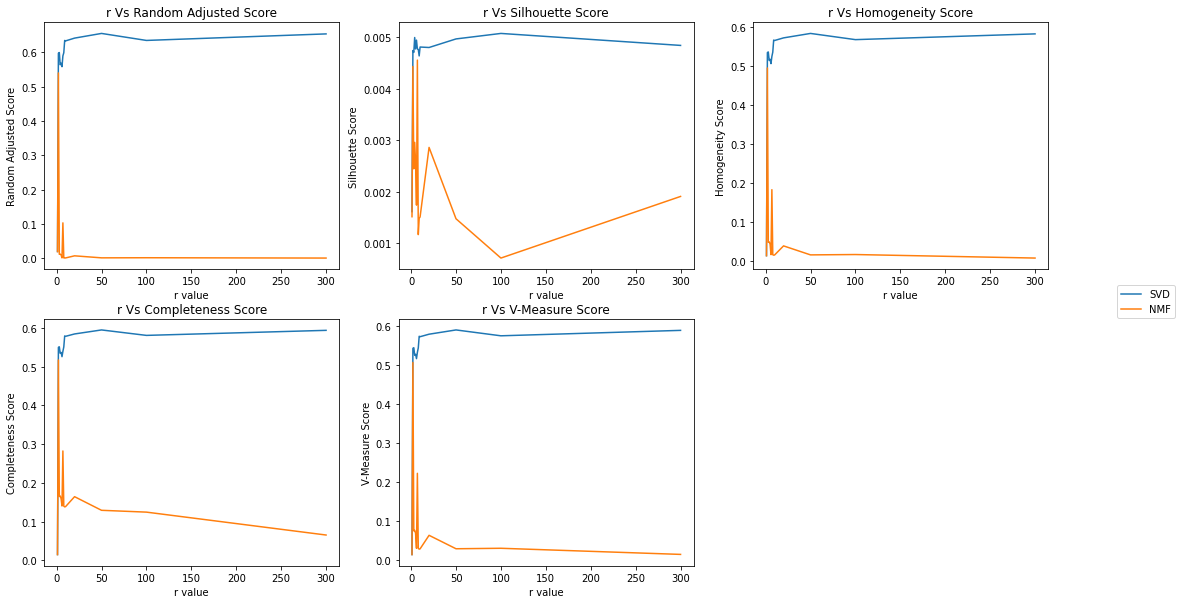

In [10]:
# plot metrics vs r
fig = plt.figure(figsize=(18, 10))
axes = fig.subplots(nrows=2, ncols=3)

axes[0, 0].plot(r,svd_adj_rand_score, label='SVD')
axes[0, 0].plot(r,nmf_adj_rand_score, label='NMF')
axes[0, 0].title.set_text('r Vs Random Adjusted Score')
axes[0, 0].set_xlabel('r value')
axes[0, 0].set_ylabel('Random Adjusted Score')

axes[0, 1].plot(r,svd_sil_score, label='SVD')
axes[0, 1].plot(r,nmf_sil_score, label='NMF')
axes[0, 1].title.set_text('r Vs Silhouette Score')
axes[0, 1].set_xlabel('r value')
axes[0, 1].set_ylabel('Silhouette Score')

axes[0, 2].plot(r,svd_hom_score, label='SVD')
axes[0, 2].plot(r,nmf_hom_score, label='NMF')
axes[0, 2].title.set_text('r Vs Homogeneity Score')
axes[0, 2].set_xlabel('r value')
axes[0, 2].set_ylabel('Homogeneity Score')

axes[1, 0].plot(r,svd_comp_score, label='SVD')
axes[1, 0].plot(r,nmf_comp_score, label='NMF')
axes[1, 0].title.set_text('r Vs Completeness Score')
axes[1, 0].set_xlabel('r value')
axes[1, 0].set_ylabel('Completeness Score')

axes[1, 1].plot(r,svd_v_score, label='SVD')
axes[1, 1].plot(r,nmf_v_score, label='NMF')
axes[1, 1].title.set_text('r Vs V-Measure Score')
axes[1, 1].set_xlabel('r value')
axes[1, 1].set_ylabel('V-Measure Score')

axes[1, 2].axis('off')

fig.legend(['SVD','NMF'], loc='center right')

plt.show()


In [11]:
import statistics
from statistics import mode

# find best r value for svd and nmf
svd_score=[svd_adj_rand_score, svd_sil_score, svd_hom_score, svd_comp_score, svd_v_score]
argmaxes=[]
for i in svd_score:
    argmaxes.append(i.index(max(i)))
svd_bestr_ind=round(mode(argmaxes))
print('Best SVD r value: ',r[svd_bestr_ind])

nmf_score=[nmf_adj_rand_score, nmf_sil_score, nmf_hom_score, nmf_comp_score, nmf_v_score]
argmaxes=[]
for i in nmf_score:
    argmaxes.append(i.index(max(i)))
nmf_bestr_ind=round(mode(argmaxes))
print('Best NMF r value: ',r[nmf_bestr_ind])

Best SVD r value:  50
Best NMF r value:  2


### Question 6

***How do you explain the non-monotonic behavior of the measures as r increases?***

While dimensionality reduction can help us work with noisy data and to reduce algorithm run time, it may also cause the data to lose information such as noise. So as r initially increases, our Kmeans clusters may be inaccurate as we truncated too much of the data; however, as r increases, we may see the scores begin to increase and then decrease. This initial increase implies we have a good trade off between the scores and how much of the data was truncated. The eventual decrease can imply that as our truncated data gets larger, more noise is being introduced; this can lead to an inaccurate clustering by Kmeans and the decreased score. Therefore, due to this, we can see the non-monotonic behaviour of the measures as r increases. 

### QUESTION 7

***Are these measures on average better than those computed in Question 3?***
- The average measures for the SVD and NMF metrics are shown below. Both performed worse than those computed in Question 3; however, the SVD metrics are a lot closer to those computed in Question 3 than using the NMF. 

In [12]:
# print average metrics
print("SVD Metrics: ")
print("Homogeneity: ", np.mean(svd_hom_score))
print("Completeness: ",np.mean(svd_comp_score))
print("V-measure: ", np.mean(svd_v_score))
print("Adjusted Rand-Index: ", np.mean(svd_adj_rand_score))
print("Silhouette Coefficient: ", np.mean(svd_sil_score))

print("\nNMF Metrics: ")
print("Homogeneity: ", np.mean(nmf_hom_score))
print("Completeness: ",np.mean(nmf_comp_score))
print("V-measure: ", np.mean(nmf_v_score))
print("Adjusted Rand-Index: ", np.mean(nmf_adj_rand_score))
print("Silhouette Coefficient: ", np.mean(nmf_sil_score))

SVD Metrics: 
Homogeneity:  0.5086295760481007
Completeness:  0.5226573391383235
V-measure:  0.515542491271773
Adjusted Rand-Index:  0.567182526171996
Silhouette Coefficient:  0.004599261311042333

NMF Metrics: 
Homogeneity:  0.0704770686887141
Completeness:  0.16756615651774417
V-measure:  0.08748731407893089
Adjusted Rand-Index:  0.051330192251747724
Silhouette Coefficient:  0.0022365449663991305


### QUESTION 8
***Visualize the clustering results for:***
- ***SVD with your optimal choice of r for K-Means clustering***
- ***NMF with your choice of r for K-Means clustering.***

The clustering results are shown below.

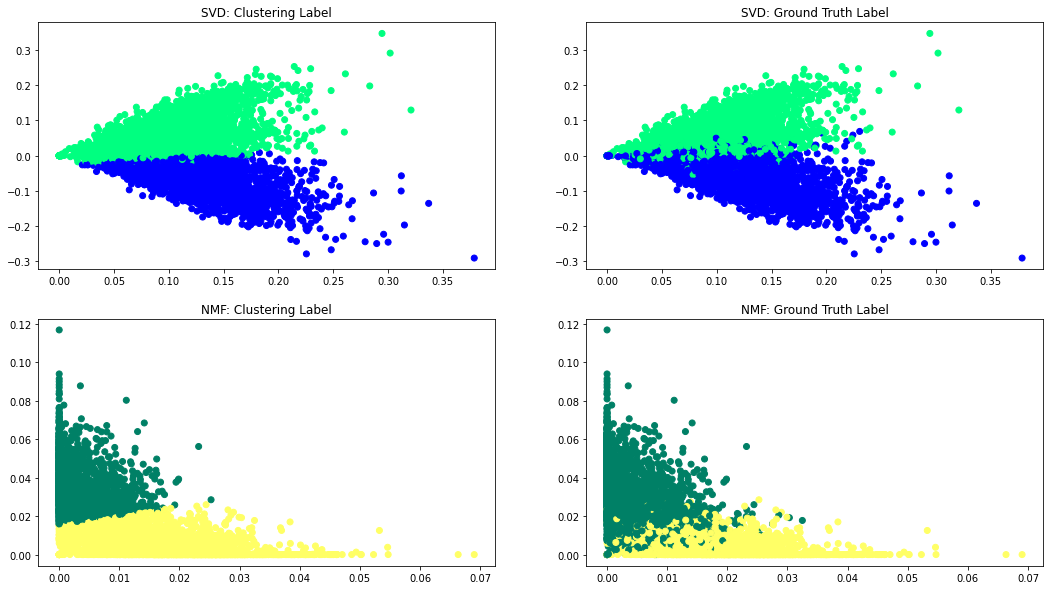

In [13]:
# plot clustering results
svd_50 = TruncatedSVD(n_components=50, random_state=0)
trunc_svd = svd_50.fit_transform(newsgroups_tfidf)

nmf_2 = NMF(n_components=2, random_state=0, init='random', max_iter=500)
trunc_nmf = nmf_2.fit_transform(newsgroups_tfidf)

fig = plt.figure(figsize=(18, 10))
axes = fig.subplots(nrows=2, ncols=2)

kmeans.fit(trunc_svd)
axes[0, 0].scatter(trunc_svd[:,0], trunc_svd[:,1],c=kmeans.labels_, cmap=plt.cm.winter)
axes[0, 0].title.set_text('SVD: Clustering Label')

axes[0, 1].scatter(trunc_svd[:,0], trunc_svd[:,1],c=category_to_class, cmap=plt.cm.winter)
axes[0, 1].title.set_text('SVD: Ground Truth Label')

kmeans.fit(trunc_nmf)
axes[1, 0].scatter(trunc_nmf[:,0], trunc_nmf[:,1],c=kmeans.labels_, cmap=plt.cm.summer)
axes[1, 0].title.set_text('NMF: Clustering Label')

axes[1, 1].scatter(trunc_nmf[:,0], trunc_nmf[:,1],c=category_to_class, cmap=plt.cm.summer)
axes[1, 1].title.set_text('NMF: Ground Truth Label')

### QUESTION 9
***What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?***
- Based on the plots above, it appears that the labels for clustering and the groung truth are generally very similar; however, the ground truth labels imply that there is a good amount of overlap between the labels. This is not shown in the clustering label plot for NMF and SVD as there is a more clear cut line between the two labels. The data does not have a spherical distribution and are instead distributed in more of a triangular shape with centroids for each label close to each other. There are also a few outliers that are farther away from the main cluster. Since K-Means clustering assumes that there is a spherical distribution, the data distribution is not ideal. 

### QUESTION 10

***Load documents with the same configuration as in Question 1, but for ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality using BOTH NMF and SVD (specify settings you choose and why), and perform K-Means clustering with k=20. Visualize the contingency matrix and report the five clustering metrics (DO BOTH NMF AND SVD).***
- The contingency matrix and metrics are shown below. To find the best r value for the NMF and SVD, the top 5 scoring r values for each metric were recorded. Among these r values, the most occuring value was chosen. In the case of finding the best r value for the SVD, there was a tie between r=8, 20, 50, and 300. For this, we chose r=20 as it scored closer to the top more often compared to the other r values. For the NMF, the best r value was r=50. 

In [14]:
# load data
newsgroups = fetch_20newsgroups(remove=('headers', 'footers'))

# count vectorizer on corpus
tf_vectorizer = CountVectorizer(min_df = 3, stop_words='english')
newsgroups_vectorized = tf_vectorizer.fit_transform(newsgroups.data)

# count vector to TF-IDF
transformer = TfidfTransformer()
newsgroups_tfidf = transformer.fit_transform(newsgroups_vectorized)

kmeans = KMeans(random_state=0, n_clusters=20, max_iter=1000, n_init=30)

In [15]:
import pandas as pd 

# search for best r value for SVD
r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
svd_adj_rand_score, svd_sil_score, svd_hom_score, svd_comp_score, svd_v_score = SVD_score(r,20,newsgroups_tfidf, newsgroups.target)

svd_score=[svd_adj_rand_score, svd_sil_score, svd_hom_score, svd_comp_score, svd_v_score]
argmaxes=[]
for i in svd_score:
    sort=list(np.argsort(i))
    sort.reverse()
    argmaxes.extend(sort[:5])
svd_top5_ind=np.array(argmaxes).reshape(5,-1)
print(svd_top5_ind)

[[ 8  9  7  6  5]
 [11 10 12 13  9]
 [ 9 10  7 11 13]
 [12 13 11 10  7]
 [13 10 11 12  7]]


In [16]:
svd_bestr = TruncatedSVD(n_components=20, random_state=0)
trunc_svd = svd_bestr.fit_transform(newsgroups_tfidf)
kmeans.fit(trunc_svd)

# print clustering measures
print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, kmeans.labels_))
print("Completeness: ",cluster. completeness_score(newsgroups.target, kmeans.labels_))
print("V-measure: ", cluster.v_measure_score(newsgroups.target, kmeans.labels_))
print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, kmeans.labels_))
print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, kmeans.labels_, sample_size=2000))

Homogeneity:  0.3375148402474223
Completeness:  0.3915122526602102
V-measure:  0.3625138124414301
Adjusted Rand-Index:  0.11564055013672209
Silhouette Coefficient:  0.007619769075544514


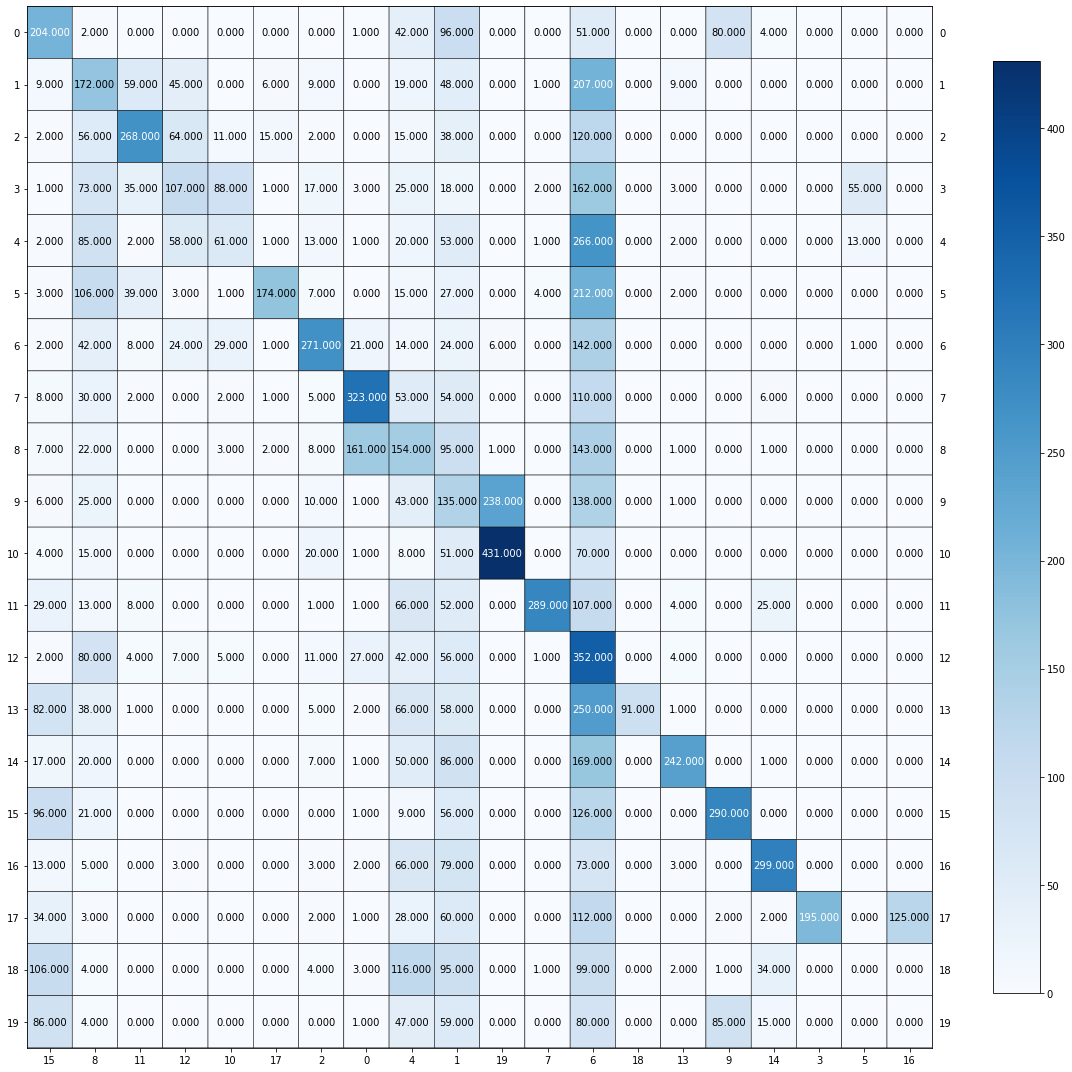

In [20]:
from plotmat import plot_mat 
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# plot confusion matrix
cm = confusion_matrix(newsgroups.target, kmeans.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

In [21]:
# search for best r value for NMF
r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
nmf_adj_rand_score, nmf_sil_score, nmf_hom_score, nmf_comp_score, nmf_v_score= NMF_score(r,20, newsgroups_tfidf, newsgroups.target)

nmf_score=[nmf_adj_rand_score, nmf_sil_score, nmf_hom_score, nmf_comp_score, nmf_v_score]
argmaxes=[]
for i in nmf_score:
    argmaxes.append(i.index(max(i)))
nmf_bestr_ind=round(mode(argmaxes))
print('Best NMF r value: ',r[nmf_bestr_ind])


Best NMF r value:  50


In [22]:
nmf_bestr = NMF(n_components=50, random_state=0, init='random', max_iter=500)
trunc_nmf = nmf_bestr.fit_transform(newsgroups_tfidf)
kmeans.fit(trunc_nmf)

# print clustering measures
print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, kmeans.labels_))
print("Completeness: ",cluster. completeness_score(newsgroups.target, kmeans.labels_))
print("V-measure: ", cluster.v_measure_score(newsgroups.target, kmeans.labels_))
print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, kmeans.labels_))
print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, kmeans.labels_, sample_size=2000))

Homogeneity:  0.2760010367197732
Completeness:  0.42097610555511633
V-measure:  0.33341076635089767
Adjusted Rand-Index:  0.05119369194370699
Silhouette Coefficient:  0.003554015532299742


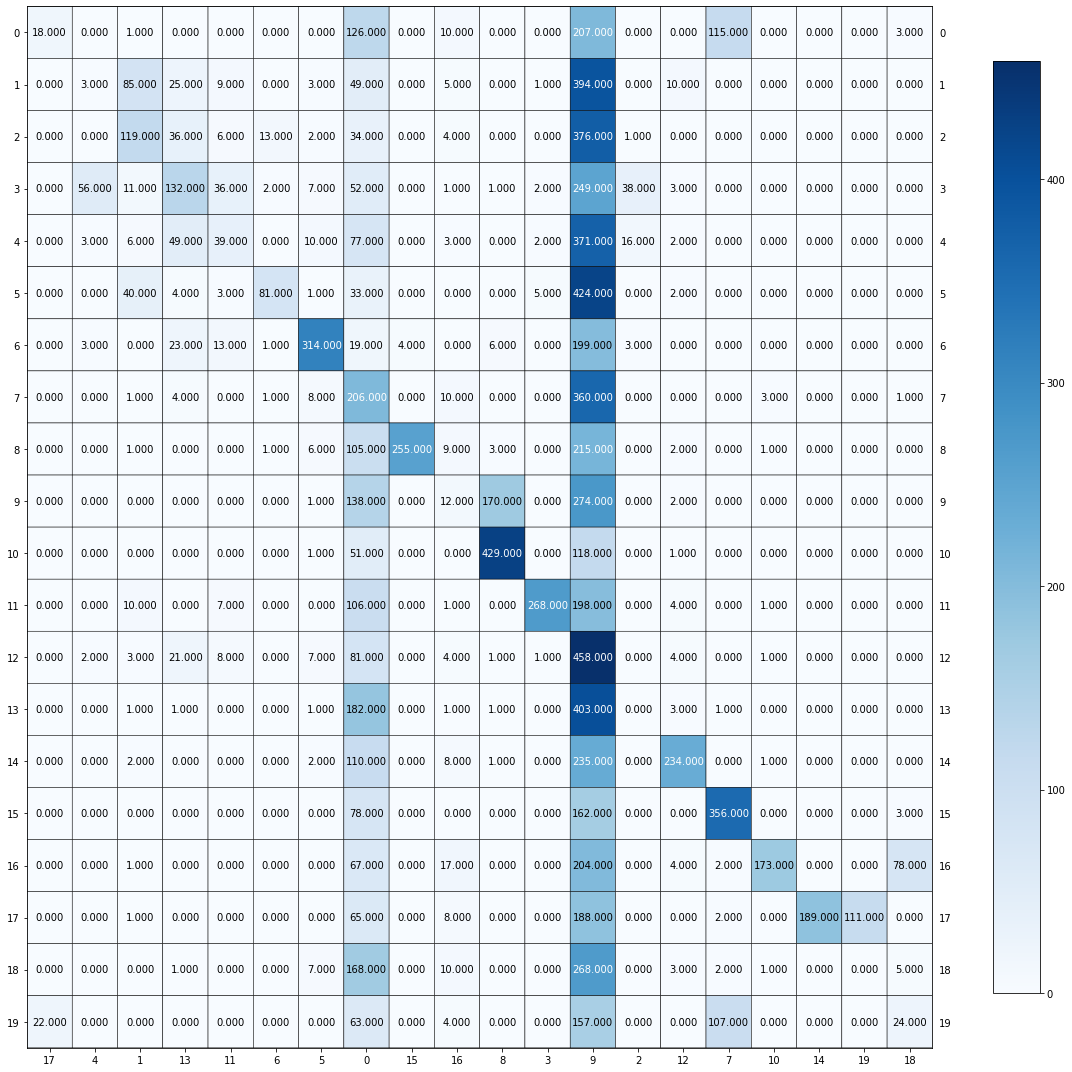

In [23]:
# plot confusion matrix
cm = confusion_matrix(newsgroups.target, kmeans.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

### QUESTION 11:
***Reduce the dimension of your dataset with UMAP. Consider the following settings: n components = [5, 20, 200], metric = ”cosine” vs. ”euclidean”. If ”cosine” metric fails, please look at the FAQ at the end of this spec. Report the permuted contingency matrix and the five clustering evaluation metrics
for the different combinations (6 combinations).***
- The 6 contingency matrices and their metrics are shown below.

In [26]:
import umap.umap_ as umap

def umap_conf_mat(tfidf, target, metric, n):
    print('\nUMAP Results using', metric,'& n_components =', n, ': ')
    umap_cosine = umap.UMAP(n_components=n, metric=metric, random_state=0)
    umap_trunc = umap_cosine.fit_transform(tfidf)

    kmeans = KMeans(random_state=0, n_clusters=20, max_iter=1000, n_init=30)
    kmeans.fit(umap_trunc)

    print("Homogeneity: ", cluster.homogeneity_score(target, kmeans.labels_))
    print("Completeness: ",cluster. completeness_score(target, kmeans.labels_))
    print("V-measure: ", cluster.v_measure_score(target, kmeans.labels_))
    print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(target, kmeans.labels_))
    print("Silhouette Coefficient: ", cluster.silhouette_score(tfidf, kmeans.labels_, sample_size=2000))

    cm = confusion_matrix(target, kmeans.labels_)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))


UMAP Results using cosine & n_components = 5 : 
Homogeneity:  0.5657783987469761
Completeness:  0.5832226235435638
V-measure:  0.574368091341958
Adjusted Rand-Index:  0.4398119211481499
Silhouette Coefficient:  -0.27971750226117115


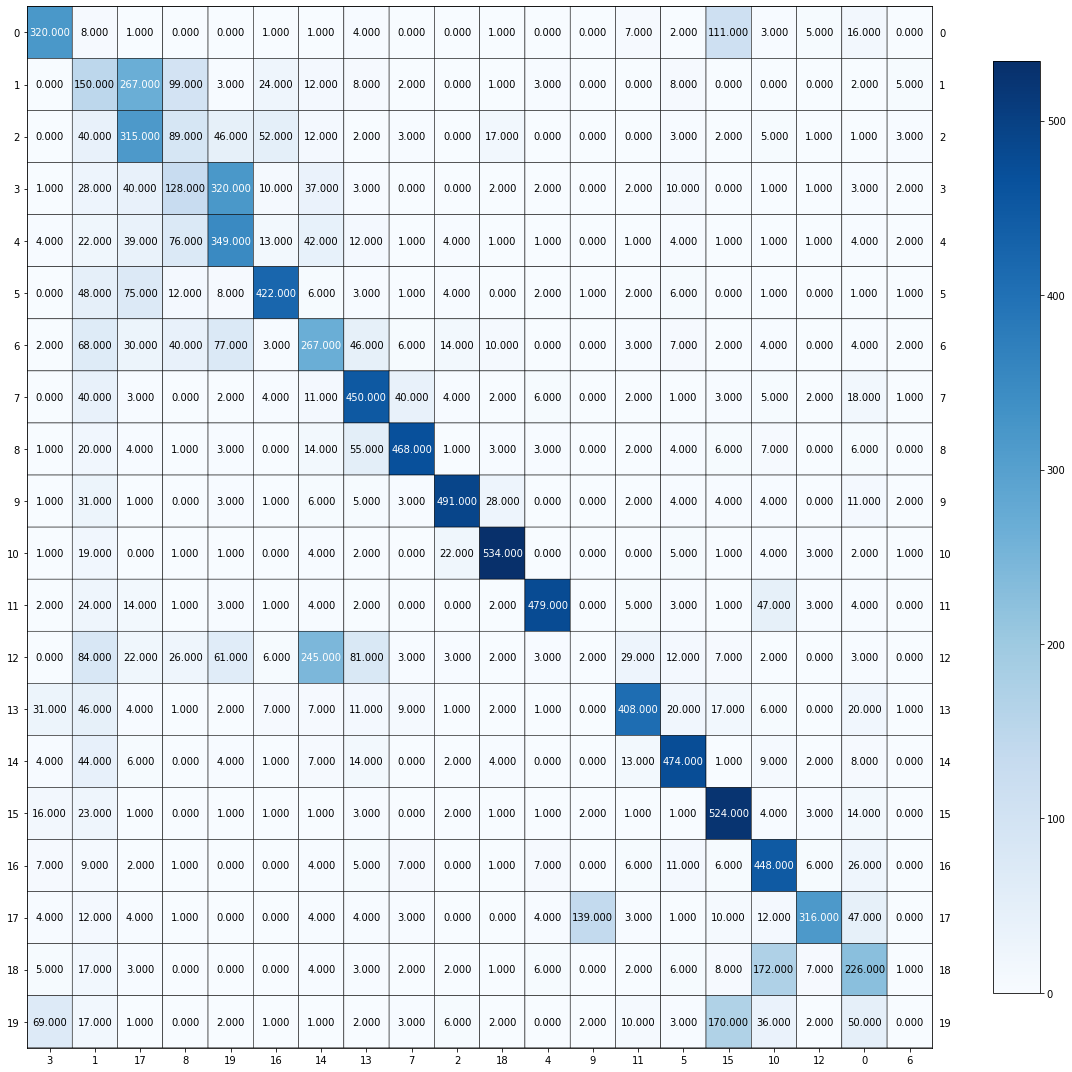


UMAP Results using cosine & n_components = 20 : 
Homogeneity:  0.5666243654495476
Completeness:  0.5839121209953368
V-measure:  0.5751383618604289
Adjusted Rand-Index:  0.4416886162604823
Silhouette Coefficient:  -0.28202213269660276


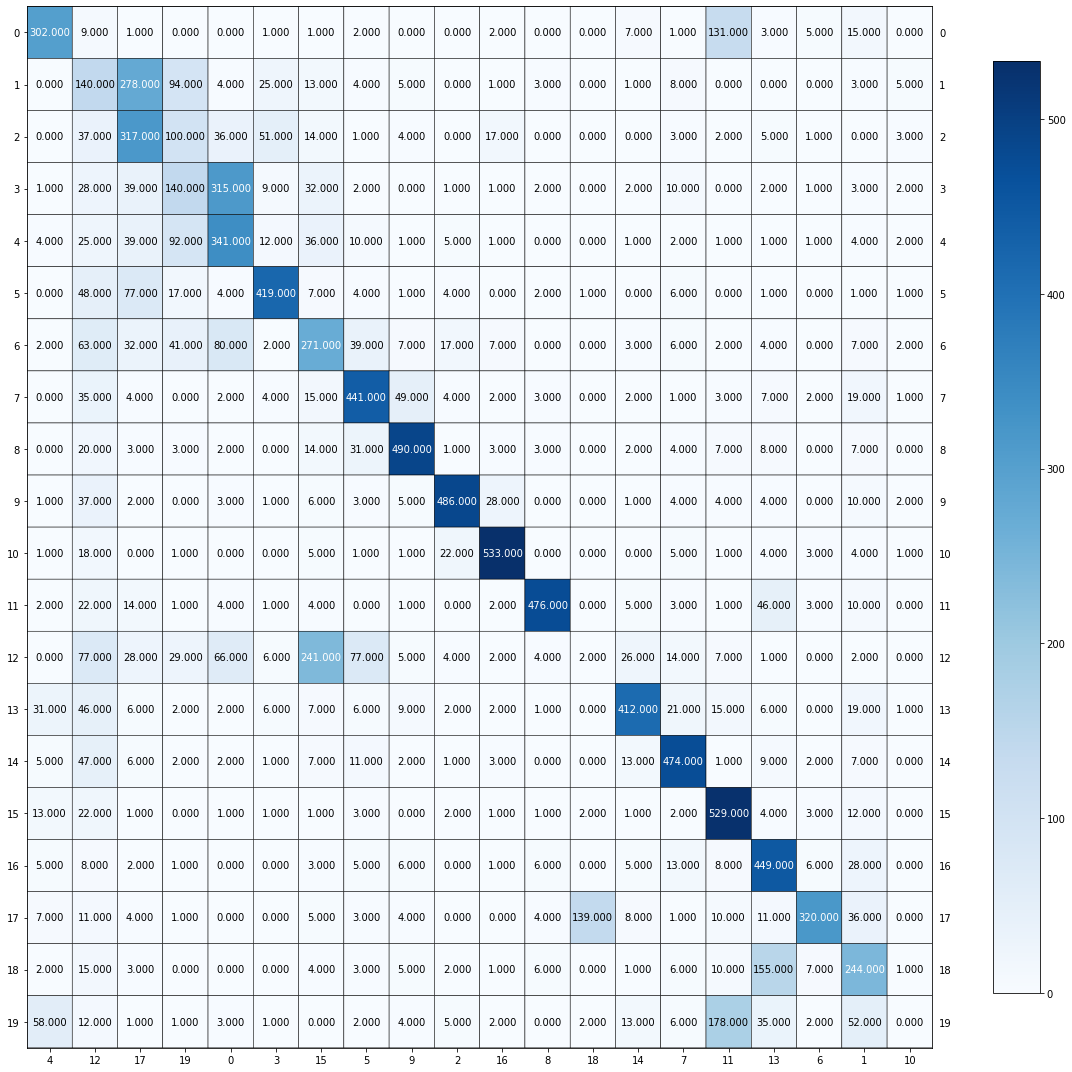


UMAP Results using cosine & n_components = 200 : 
Homogeneity:  0.5729025800113658
Completeness:  0.5967040622116844
V-measure:  0.5845611411620956
Adjusted Rand-Index:  0.44513079859249705
Silhouette Coefficient:  -0.28012370402924947


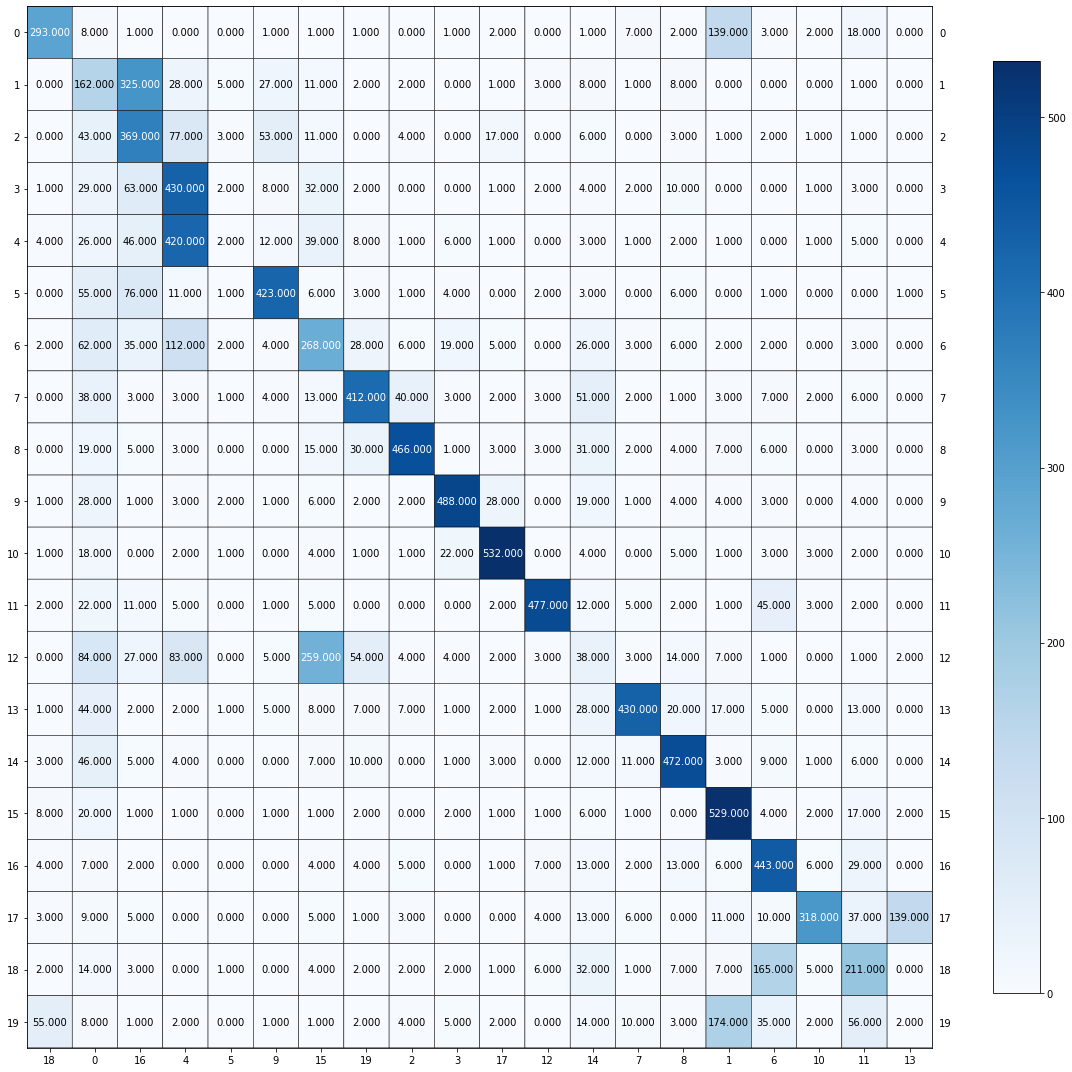

In [27]:
for n in [5, 20, 200]:
    umap_conf_mat(newsgroups_tfidf, newsgroups.target, 'cosine', n)


UMAP Results using euclidean & n_components = 5 : 
Homogeneity:  0.008550105125850227
Completeness:  0.008590218955555269
V-measure:  0.008570115101119635
Adjusted Rand-Index:  0.0012058648969454344
Silhouette Coefficient:  -0.007972250984031485


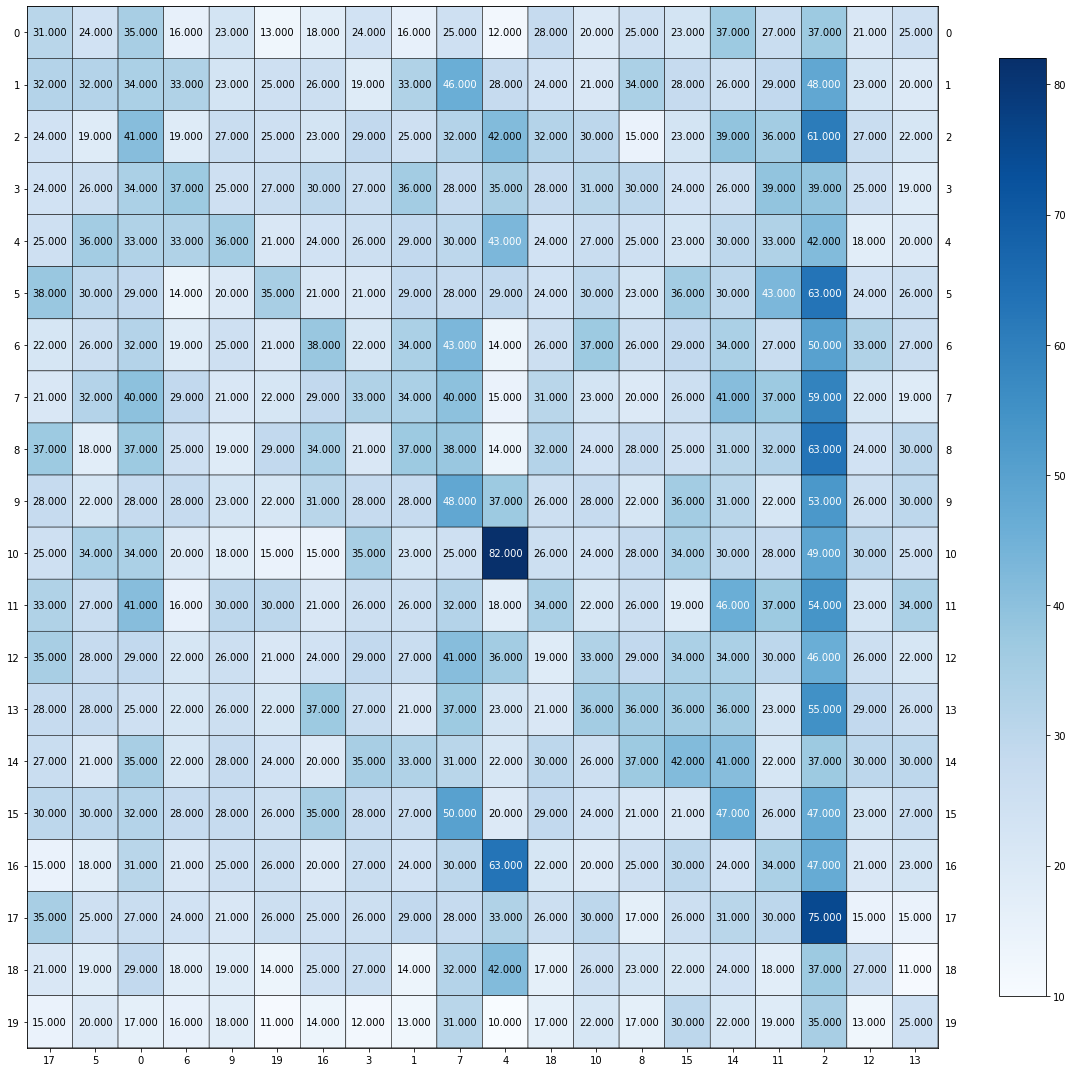


UMAP Results using euclidean & n_components = 20 : 
Homogeneity:  0.00858278999730706
Completeness:  0.008751460483524863
V-measure:  0.008666304618464281
Adjusted Rand-Index:  0.0009779127571098191
Silhouette Coefficient:  -0.011147477179816564


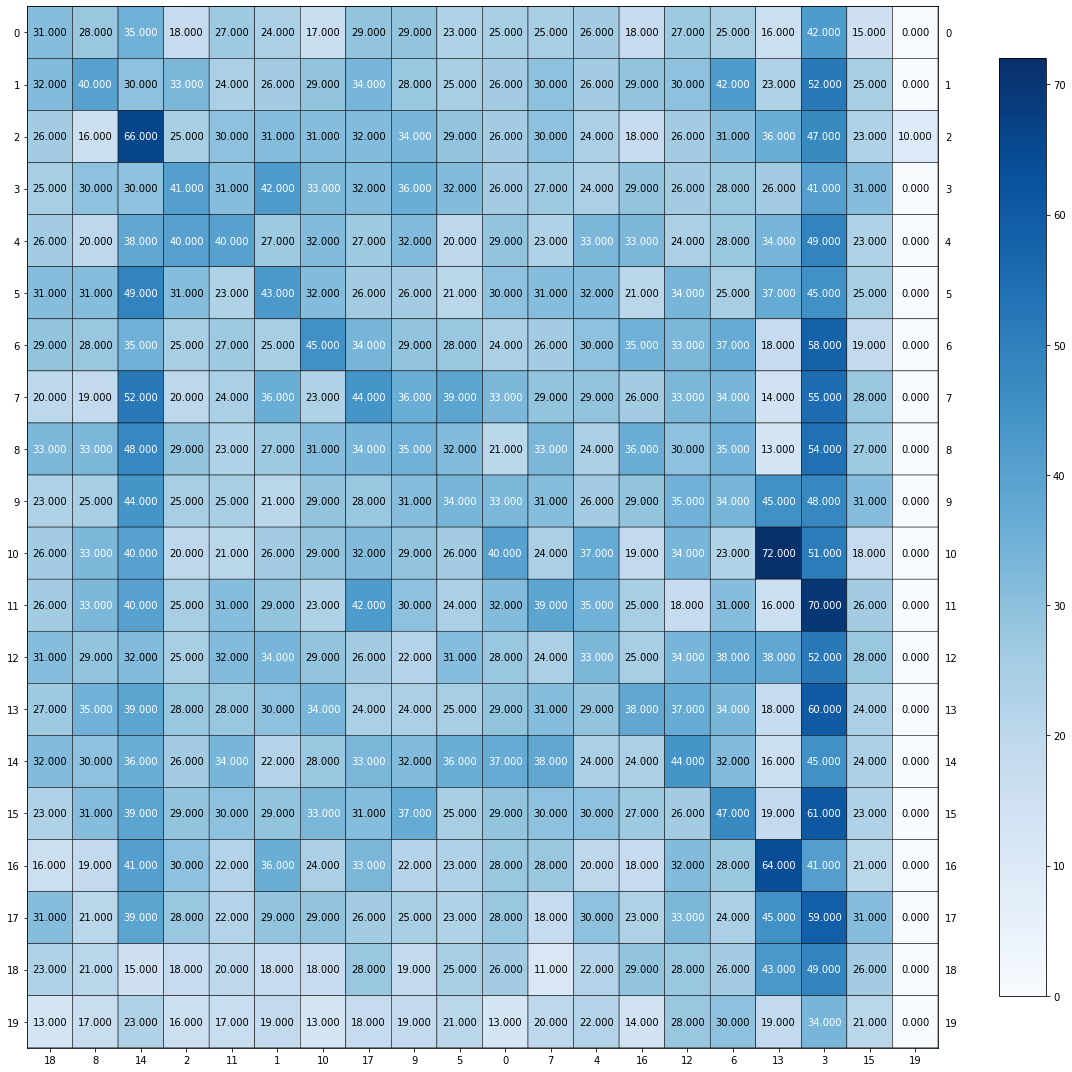


UMAP Results using euclidean & n_components = 200 : 
Homogeneity:  0.008358766144836919
Completeness:  0.00854518608745854
V-measure:  0.008450948179173893
Adjusted Rand-Index:  0.0008933207124191127
Silhouette Coefficient:  -0.006250349530658955


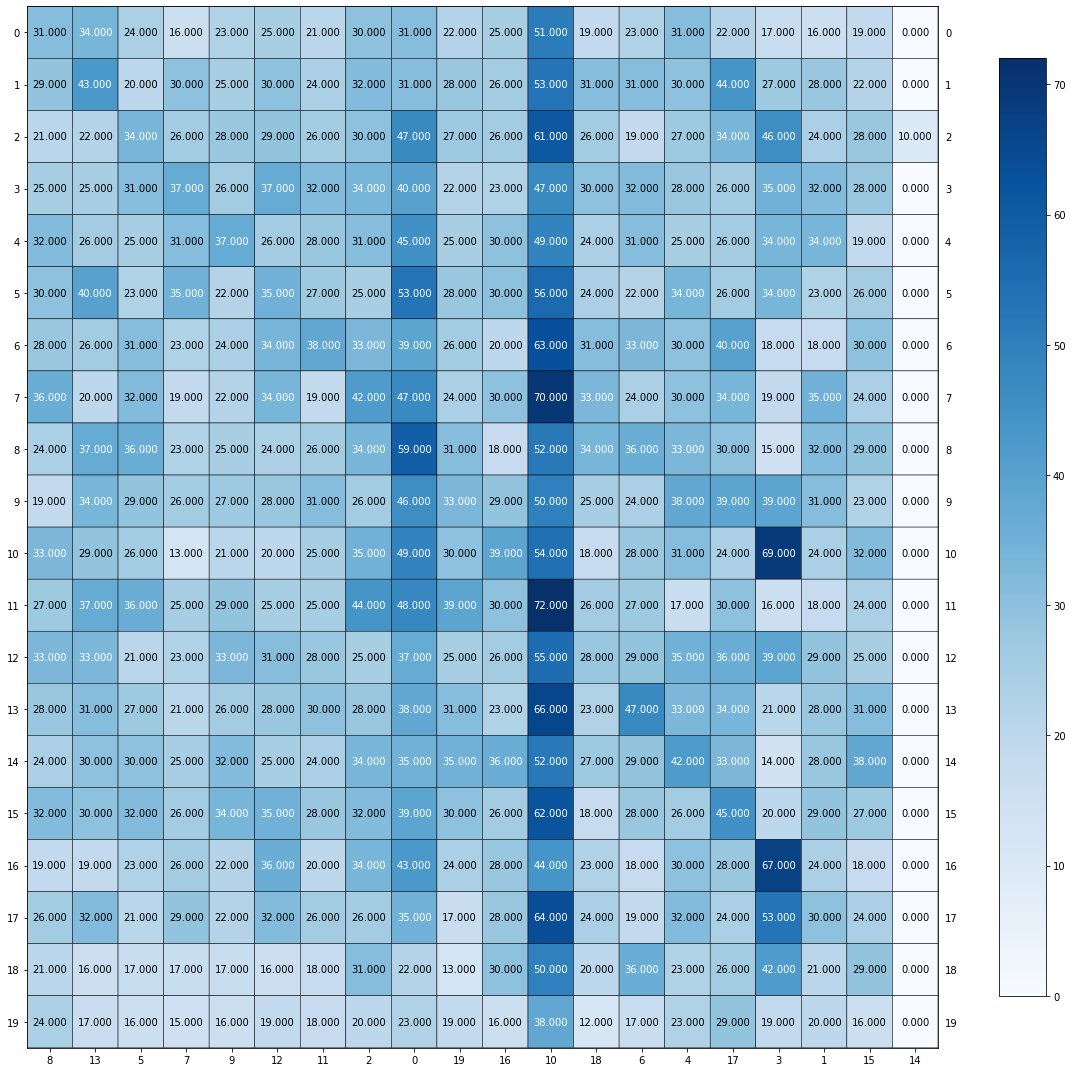

In [28]:
for n in [5, 20, 200]:
    umap_conf_mat(newsgroups_tfidf, newsgroups.target, 'euclidean', n)

### QUESTION 12
***Analyze the contingency matrices. Which setting works best and why? What about for each metric choice?***
- In general, using `metric=cosine` for the UMAP dimensionality reduction, it was able to better split the data into clusters as seen from the strong diagonals in the contingency matrix. Additonally, the homogeneity, completeness, v-measure, and adjusted random index scores consistently scored above 0.4 for all n_component values; these all indicate that the UMAP method for dimensionality reduction performed better than using SVD/PCA and NMF for dimensionality reduction as these metrics were higher than the metrics for the PCA and NMF in those regards. However, using `metric=cosine` caused the silhouette coefficient to be less than 0 for all n_component values, which indicates there is a large amount of clusters most likely being assigned the wrong class. This is also evident in there being some semi-strongly coloured squares outside the diagonal on the plots. Since most of the scores are very comparable, the best setting for this metric choice is one that has the least negative silhouette score (less samples assigned to the wrong cluster), which is `n_components=5`.
- In contrast, the UMAP dimensionality reduction using `metric=euclidian` had homogeneity, completeness, v-measure, and adjusted random index scores close to 0 for all n_componenet values; this indicates it was doing a poorer job of classifying the dataset, especially compared to using PCA or NMF for dimensionality reduction. The silhouette coefficient for all n_component values are also negative, but much closer to 0; this indicates it was not able to form any real, meaningful clusters. This is evident in how all 3 confusion matrixes have much of the data spread out; a good confusion matrix would show 20 strongly coloured squares in the plot. While `metric=euclidian` is a poor metric to use for UMAP in general, the best setting for it is `n_components=5` as well due the confusion matrix having less strongly coloured squares spread out across the matrix plot. This implies that there are more clusters that are more homogeneous compared to the other confusion matrixes.
- Therefore, the better metric choice is `cosine`, specifically with `n_components=5`. 

### QUESTION 13

***So far, we have attempted K-Means clustering with 4 different representation
learning techniques (sparse TF-IDF representation, PCA-reduced, NMF-reduced, UMAP-reduced). Compare and contrast the clustering results across the 4 choices, and suggest an approach that is best for the K-Means clustering task on the 20-class text data. Choose any choice of clustering metrics for your comparison.***
- The UMAP reduced matrix with the `cosine` metric had the best performance with `n_components=5` due to the confusion matrix having the strong diagonal with a few coloured squares scattered around the plot; additionally, it had the highest V-measure score of 0.574368091341958. Other than the silhouette score, it had the highest metrics in general. However, to compare the 4 different approaches, we will use the V measure score as it considers both the homogeneity and completeness score; the homogenity score describes how similar samples in a cluster are to each other and how many similar samples are clustered together. This metric will allow us to determine how well the clusters are formed. 
- Doing Kmeans with the `n_components=20` PCA reduced also resulted in a contingency matrix with a strong matrix as well; however, there are more coloured squares outside the diagonal as well as a strongly coloured column. This implies that it is not able to cluster the data as well as using UMAP. This is evident from the V measure score (0.3625138124414301). 
- Doing the Kmeans clustering on just the TF-IDF matrix alone had similar results to that of the PCA reduced data as seen below. It again has a strong diagonal with many coloured squares outside the diagonal and along 1 column. This had a slightly higher V-measure score than that of using the PCA reduced data; this had a v measure score of 0.372655921450351. 
- Not considering the UMAP matrix with the `euclidian` matrix as it performed worse than the `cosine` metric, the NMF reduced data with `n_components=50` had the worst performace. This is clearly evident based on the confusion matrix not having a clear diagonal; in fact, it has a clear coloured column, but this actually implies that most samples actually belong in the same cluster. It had the lowest v measure score of 0.33341076635089767. 
- Therefore, based on the V-measure score and the contingency matrix, the UMAP reduced matrix with the `cosine` metric is the best approach for the K-Means clustering task for the 20 classes.

Kmeans Clustering with TF-IDF matrix (no dimensionality reduction): 
Homogeneity:  0.3483560648768872
Completeness:  0.40060010276971214
V-measure:  0.372655921450351
Adjusted Rand-Index:  0.12391707104061779
Silhouette Coefficient:  0.006607687100659025


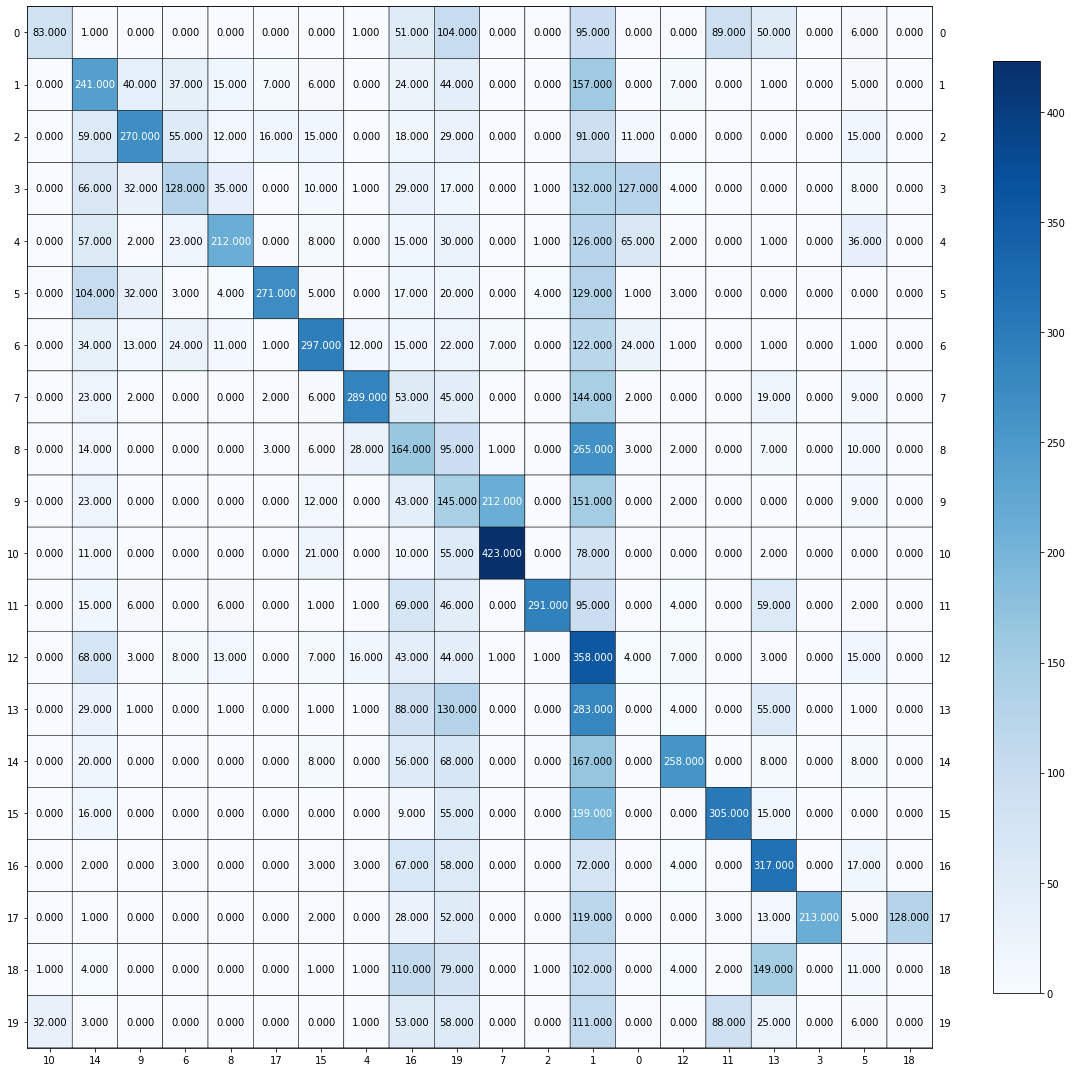

In [30]:
print('Kmeans Clustering with TF-IDF matrix (no dimensionality reduction): ')
kmeans = KMeans(random_state=0, n_clusters=20, max_iter=1000, n_init=30)
kmeans.fit(newsgroups_tfidf )
# print clustering measures
print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, kmeans.labels_))
print("Completeness: ",cluster. completeness_score(newsgroups.target, kmeans.labels_))
print("V-measure: ", cluster.v_measure_score(newsgroups.target, kmeans.labels_))
print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, kmeans.labels_))
print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, kmeans.labels_, sample_size=2000))
cm = confusion_matrix(newsgroups.target, kmeans.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

### QUESTION 14
***Use UMAP to reduce the dimensionality properly, and perform Agglomerative clustering with n_clusters=20 . Compare the performance of “ward” and “single”
linkage criteria. Report the five clustering evaluation metrics for each case.***

In [31]:
from sklearn.cluster import AgglomerativeClustering

umap_cosine = umap.UMAP(n_components=5, metric='cosine', random_state=0)
umap_trunc = umap_cosine.fit_transform(newsgroups_tfidf)

ward_clustering = AgglomerativeClustering(n_clusters=20, linkage='ward')
ward_clusted = ward_clustering.fit(umap_trunc)

print("Agglomerative Clustering using 'ward' metrics: ")
print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, ward_clusted.labels_))
print("Completeness: ",cluster. completeness_score(newsgroups.target, ward_clusted.labels_))
print("V-measure: ", cluster.v_measure_score(newsgroups.target, ward_clusted.labels_))
print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, ward_clusted.labels_))
print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, ward_clusted.labels_, sample_size=2000))

Agglomerative Clustering using 'ward' metrics: 
Homogeneity:  0.5500122253431315
Completeness:  0.5685907333721262
V-measure:  0.5591471971979518
Adjusted Rand-Index:  0.4106836200412273
Silhouette Coefficient:  -0.27912183282399905


In [32]:
single_clustering = AgglomerativeClustering(n_clusters=20, linkage='single')
single_clusted = single_clustering.fit(umap_trunc)

print("Agglomerative Clustering using 'single' metrics: ")
print("Homogeneity: ", cluster.homogeneity_score(newsgroups.target, single_clusted.labels_))
print("Completeness: ",cluster. completeness_score(newsgroups.target, single_clusted.labels_))
print("V-measure: ", cluster.v_measure_score(newsgroups.target, single_clusted.labels_))
print("Adjusted Rand-Index: ", cluster.adjusted_rand_score(newsgroups.target, single_clusted.labels_))
print("Silhouette Coefficient: ", cluster.silhouette_score(newsgroups_tfidf, single_clusted.labels_, sample_size=2000))

Agglomerative Clustering using 'single' metrics: 
Homogeneity:  0.023186845600586287
Completeness:  0.39264978720295496
V-measure:  0.043787917046159995
Adjusted Rand-Index:  0.0007960104643891622
Silhouette Coefficient:  -0.28436279723152746


### QUESTION 15
***Apply HDBSCAN on UMAP-transformed 20-category data. Use min_cluster_size=100 . Vary the min cluster size among 20, 100, 200 and report your findings in terms of the five clustering evaluation metrics - you will plot the best contingency matrix in the next question. Feel free to try modifying other parameters in HDBSCAN to get better performance.***

### QUESTION 16
***Plot the contingency matrix for the best clustering model from Question 15.
How many clusters are given by the model? What does “-1” mean for the clustering labels? Interpret the contingency matrix considering the answer to these questions.***

### QUESTION 17
***Based on your experiments, which dimensionality reduction technique and clustering methods worked best together for 20-class text data and why? Follow the table below. If UMAP takes too long to converge, consider running it once and saving the intermediate results in a pickle file. Hint: DBSCAN and HDBSCAN do not accept the number of clusters as an input parameter. So pay close attention to how the different clustering metrics are being computed for these methods.***

| Module | Alternatives | Hyperparameters |
| --- | --- | --- |
| Dimensionality Reduction | None | N/A |
| Dimensionality Reduction | SVD | $r = [5,20,200]$ |
| Dimensionality Reduction | NMF | $r = [5,20,200]$ |
| Dimensionality Reduction | UMAP | n_components $ = [5,20,200]$ |
| Clustering | K-Means | $k = [10,20,50]$ |
| Clustering | Agglomerative Clustering | n_clusters $ = [20]$ |
| Clustering | HDBSCAN | min_cluster_size $ = [100,200]$ |

### QUESTION 18
***Extra credit: If you can find creative ways to further enhance the clustering performance, report your method and the results you obtain.***

### QUESTION 19
***In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?***
- Since VGG is already pretrained on some dataset, it already has weights, biases, and other parameters that are set and work for the initial targets. When it is trained again on a different data set, it can use these initial weights, biases, and parameters to quicken the learning process as it doesn't have the learn how to discriminate between classes from scratch; it already has some ability to do so, but these parameters will most likely have to be changed a little. This aspect of neural networks is called transfer learning and helps to provide an advantage over traditional machine learning algorithms. This is also similar to how humans learn as they use already learned knowledge to learn new things; they do not have relearn everything to learn a new concept, even if they are completely different. 

### QUESTION 20
***In a brief paragraph explain how the helper code base is performing feature extraction.***
- The helper code base loads the flower images and crops them in the middle so it is a 224x224 px size image and does feature extration on it using the `FeatureExtractor` class. This uses the VGG16 neural network that is already pretrained. The initial part of the class creates instance variables of the labels, average pooling layer, and the first part of fully-connected layer from VGG16. It also creates a variable that flattens an image into a vector. 
- To actually extract features, it only does a forward propagation that applies weights onto the input image to get its features. It then goes through the average pooling layer to get averages from patches within the image. This then gets flattened and the first part of fully connected layer from VGG16 is then returned. 

### QUESTION 21
***How many pixels are there in the original images? How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample?***
- The original images have several sizes which as 240x160 px, 240x176 px, etc. The aspect ratios range from 0.5 to 5.5. However, since VGG only accepts inputs that are 224x224 px, each image is cropped to that size. The network extracts 4096 features per image; the `f_all` shape is (3670, 4096), which implies that there are 3670 samples with 4096 features each. 


### QUESTION 22
***Are the extracted features dense or sparse? (Compare with sparse TF-IDF features in text.)***
- The extracted features are dense. 